## CIFAR-10

### Data

In [0]:
CIFAR_DIR = '' #'cifar-10-batches-py/'

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding = 'bytes')
    return cifar_dict

In [0]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']


In [0]:
all_data = list(range(7))

In [0]:
for i, direc in zip(all_data, dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [38]:
!ls
#!unzip './cifar-10-batches-py.zip'

batches.meta  data_batch_2  data_batch_4  readme.html  test_batch
data_batch_1  data_batch_3  data_batch_5  sample_data


In [0]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [40]:
#b'sd' is an instance of byte type
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [41]:
batch_meta[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [42]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [43]:
data_batch1[b'batch_label'], data_batch2[b'batch_label']

(b'training batch 1 of 5', b'training batch 2 of 5')

In [44]:
data_batch1[b'labels'][:3]

[6, 9, 9]

In [45]:
data_batch1[b'data'][0].shape #32*32*3

(3072,)

In [46]:
data_batch1[b'filenames'][:3]

[b'leptodactylus_pentadactylus_s_000004.png',
 b'camion_s_000148.png',
 b'tipper_truck_s_001250.png']

### Display a single image using matplotlib

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [0]:
x = data_batch1[b'data']

In [49]:
x.shape #3072 = 32*32*3

(10000, 3072)

TypeError: ignored

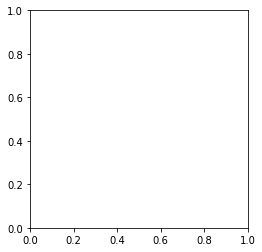

In [50]:
plt.imshow(x[0]) #be careful about the dimension

In [0]:
x = x.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)

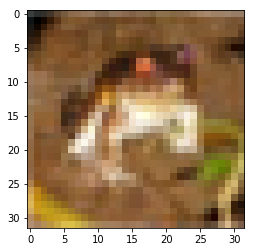

In [52]:
plt.imshow(x[0])

In [53]:
x[0].max()

255

In [54]:
(x[0]/255).max()

1.0

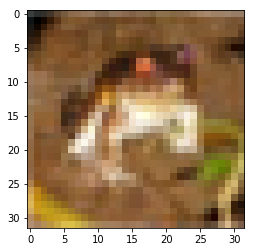

In [55]:
plt.imshow(x[0]/255)

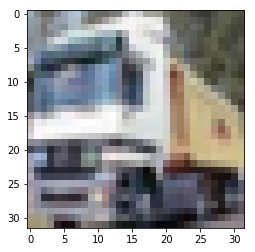

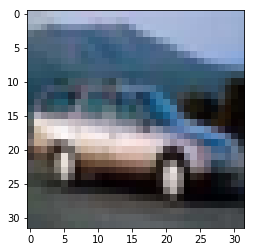

In [56]:
plt.imshow(x[1])
plt.show()
plt.imshow(x[4])
plt.show()

### Helper Functions for Dealing with Data

In [0]:
def one_hot_encode(vec, vals=10):
    """
        to encode the 10-possible labels
    """
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1 #NOT out[:, vec] = 1
    return out

In [0]:
class CifarHelper():
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1, data_batch2, data_batch3, data_batch4, data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
        
    def set_up_images(self):
        print ('setting up training images and labels')
        
        self.training_images = np.vstack([d[b'data'] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len, 3, 32, 32).transpose(0, 2, 3, 1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b'labels'] for d in self.all_train_batches]), 10)
        
        print ('setting up the test images and labels')
        
        self.test_images = np.vstack([d[b'data'] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len, 3, 32, 32).transpose(0, 2, 3, 1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b'labels'] for d in self.test_batch]), 10)
        
    def next_batch(self, batch_size):
        x = self.training_images[self.i: self.i+batch_size]
        y = self.training_labels[self.i: self.i+batch_size]
        
        self.i = (self.i+batch_size) % len(self.training_images)
        
        return x, y

In [59]:
ch = CifarHelper()
ch.set_up_images()

setting up training images and labels
setting up the test images and labels


### CNN Model

In [0]:
import tensorflow as tf

In [0]:
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [0]:
hold_prob = tf.placeholder(tf.float32)

### Helper Functions

In [0]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial_value = init_random_dist)

In [0]:
def init_bias(shape):
    init_bias = tf.truncated_normal(shape, stddev = 0.2)
    return tf.Variable(initial_value = init_bias)

In [0]:
def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides = (1, 1, 1, 1), padding='SAME')

In [0]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize = (1, 2, 2, 1), strides = [1, 2, 2, 1], padding='SAME')

In [0]:
def convolutional_layer(input_x, shape):
    w = init_weights(shape)
    b = init_bias([shape[3]]) #for each channel/filter
    return tf.nn.relu(conv2d(input_x, w)+b)

In [0]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    w = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, w)+b

### Create the Layers

In [0]:
convo_1 = convolutional_layer(x, shape = [4, 4, 3, 30])
convo_1_pooling = max_pool_2by2(convo_1)

In [0]:
convo_2 = convolutional_layer(convo_1_pooling, shape = [4, 4, 30, 60])
convo_2_pooling = max_pool_2by2(convo_2)

In [0]:
convo_3 = convolutional_layer(convo_2_pooling, shape = [4, 4, 60, 80])
convo_3_pooling = max_pool_2by2(convo_3)

Now each image is 8*8*64

In [0]:
convo_2_flat = tf.reshape(convo_3_pooling, [-1, 4*4*80])

In [0]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [0]:
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [0]:
y_pred = normal_full_layer(full_one_dropout, 10)

### LOSS FUNCTION

In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits = y_pred))

### Optimizer

In [0]:
optimier = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimier.minimize(cross_entropy)

### Session

In [0]:
init = tf.global_variables_initializer()

In [142]:
with tf.Session() as sess:
    sess.run(init)
    ACC = []
    LOSS = []
    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, {x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        if i % 100 == 0:
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            ACC.append(sess.run(acc, {x: ch.test_images, y_true: ch.test_labels, hold_prob: 1.0}))
            print (i, ACC[-1])
            LOSS.append(sess.run(cross_entropy, {x: ch.test_images, y_true: ch.test_labels, hold_prob: 1.0}))

    
        

0 0.1052
100 0.3999
200 0.4523
300 0.4874
400 0.5048
500 0.5263
600 0.5502
700 0.5754
800 0.5811
900 0.5813
1000 0.6091
1100 0.5927
1200 0.6318
1300 0.6263
1400 0.6092
1500 0.6485
1600 0.6487
1700 0.6608
1800 0.6651
1900 0.6471
2000 0.6607
2100 0.6789
2200 0.6868
2300 0.677
2400 0.669
2500 0.6811
2600 0.6915
2700 0.6931
2800 0.694
2900 0.6815
3000 0.6871
3100 0.6894
3200 0.7003
3300 0.6913
3400 0.6811
3500 0.7004
3600 0.6949
3700 0.7058
3800 0.6869
3900 0.7035
4000 0.7092
4100 0.6904
4200 0.6961
4300 0.6817
4400 0.7133
4500 0.7132
4600 0.7032
4700 0.7055
4800 0.6914
4900 0.7066


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

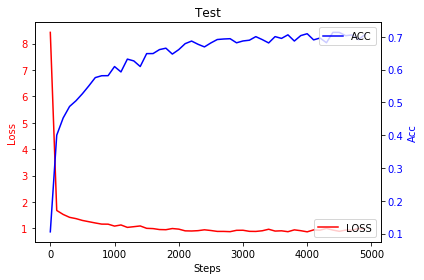

In [144]:
fig, ax1 = plt.subplots()
plt.title('Test')

ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss', color = 'r')
ax1.tick_params(axis='y', labelcolor = 'r')
ax1.plot(range(0, 5000, 100), LOSS, 'r', label = 'LOSS')
#ax1.legend()
ax1.legend(loc = 'lower right')

ax2 = ax1.twinx()
ax2.set_ylabel('Acc', color = 'b')
ax2.tick_params(axis = 'y', labelcolor = 'b')
ax2.plot(range(0, 5000, 100), ACC, 'b', label = 'ACC')
ax2.legend(loc = 'upper right')

fig.tight_layout()